In [1]:
%%time
# Imports
from utils import *

CPU times: total: 1.5 s
Wall time: 5.28 s


File-Reading

In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
user = []
ts = []
ca = []
tweets = []
mentions = []
coord = []
country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        user.append(line[0])
        ts.append(line[1])
        ca.append(line[2])
        tweets.append(line[3])
        mentions.append(line[4])
        coord.append(line[5])
        country.append(line[6])

CPU times: total: 23.5 s
Wall time: 24.3 s


# **03 - MAPPING**
### **QUESTION - 1**

In [3]:
%%time

# Use tweets and coordinates to create a mapping dataframe
mapping_df = pd.DataFrame(
    list(zip(tweets , coord)) , columns = ['tweet_id' , 'coordinates']
)

# mapping_df = from_pandas(mapping_df , npartitions = 4)

# Removing unnecessary rows
mapping_df = mapping_df[
    (mapping_df['tweet_id']!="None")
    &(mapping_df['coordinates']!="None")
].drop_duplicates()

len(mapping_df)

CPU times: total: 12.5 s
Wall time: 12.6 s


701961

In [4]:
%%time
# Long and Lat - clean up
mapping_df[['long' , 'lat']] = mapping_df['coordinates'].str.split(',' , expand = True)

# Long
mapping_df['long'] = mapping_df['long'].apply(lambda x : x[1:])#.astype('float')
mapping_df['long'] = mapping_df['long'].astype('float')

# Lat
mapping_df['lat'] = mapping_df['lat'].apply(lambda x : x[:-1])#.astype('float')
mapping_df['lat'] = mapping_df['lat'].astype('float')

mapping_df.drop('coordinates' , inplace = True , axis = 1)

# Get the coordinates as arrays
x_coord = mapping_df['long']
y_coord = mapping_df['lat']

CPU times: total: 12.6 s
Wall time: 12.6 s


In [25]:
data = {}
pops = {}

# https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts
shape_file = os.path.join(os.getcwd() , 'world_map\\TM_WORLD_BORDERS_SIMPL-0.3.shp')

with fiona.open(shape_file) as layer:
    count = 0
    for feature in layer:
        country_code = feature['properties']['NAME']
        data[country_code] = shape(feature['geometry'])

patches = []
colours = []

for c in data:
    try:
        for p in data[c].geoms:
            lons , lats = np.array(p.exterior.coords.xy)
            patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))
            # colours.append(pops[c])
    except AttributeError:
        lons , lats = np.array(data[c].exterior.coords.xy)
        patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))
        # colours.append(pops[c])

In [6]:
# fig , ax = plt.subplots()

# ax1 = ax.scatter(x_coord , y_coord , s = 0.00001 , cmap = "Blues");
# fig.colorbar(ax1 , ax = ax);
# plt.xlim(-40 , 80);
# plt.ylim(20 , 70);

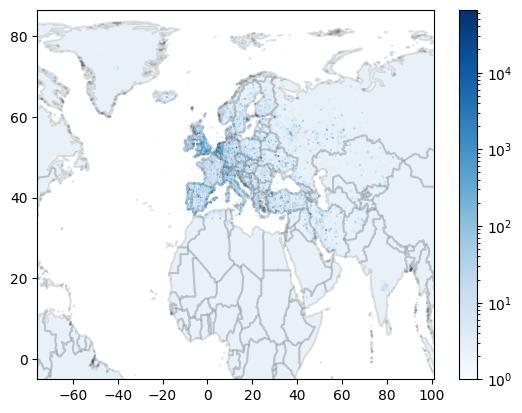

In [41]:
fig , ax = plt.subplots()
# Hexbin for tweets
ax1 = ax.hexbin(x_coord , y_coord , gridsize = 500 , bins = 'log' , cmap = 'Blues');
fig.colorbar(ax1);
# plt.colorbar();
# ax.autoscale();

# plt.set_cmap("Blues")
p = PatchCollection(patches , edgecolor = 'k' , lw = 1.5 , alpha = 0.1 , cmap = "Blues")

# Add collection to axes
ax.add_collection(p)

# plt.xlim(-20 , 60);
# plt.ylim(40 , 70);

plt.show()